In [1]:
# Using Framingham
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas_profiling
%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\us61565\Desktop\Explainability\Framingham\framingham.csv')

In [3]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
# looking at stats
pandas_profiling.ProfileReport(df)

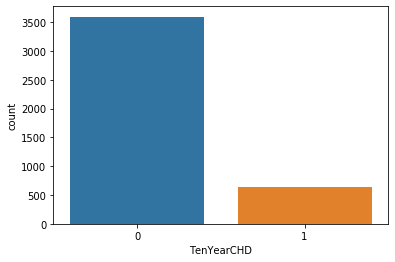

In [4]:
# Exploring the target variable
df['TenYearCHD'].value_counts(normalize = True)
sns.countplot(x='TenYearCHD',data=df)

0

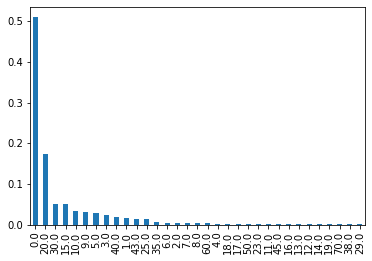

In [5]:
# Exploring cigsPerDay
df['cigsPerDay'].value_counts(normalize = True).plot(kind="bar")
df['cigsPerDay'][df['currentSmoker']==0].isna().sum()

In [6]:
# creating a boolean array of smokers
smoke = (df['currentSmoker']==1)
# applying mean to NaNs in cigsPerDay but using a set of smokers only
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())
df['cigsPerDay'][df['currentSmoker']==1].mean()

18.35624394966117

In [7]:
# Filling out missing values
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)

In [8]:
df.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

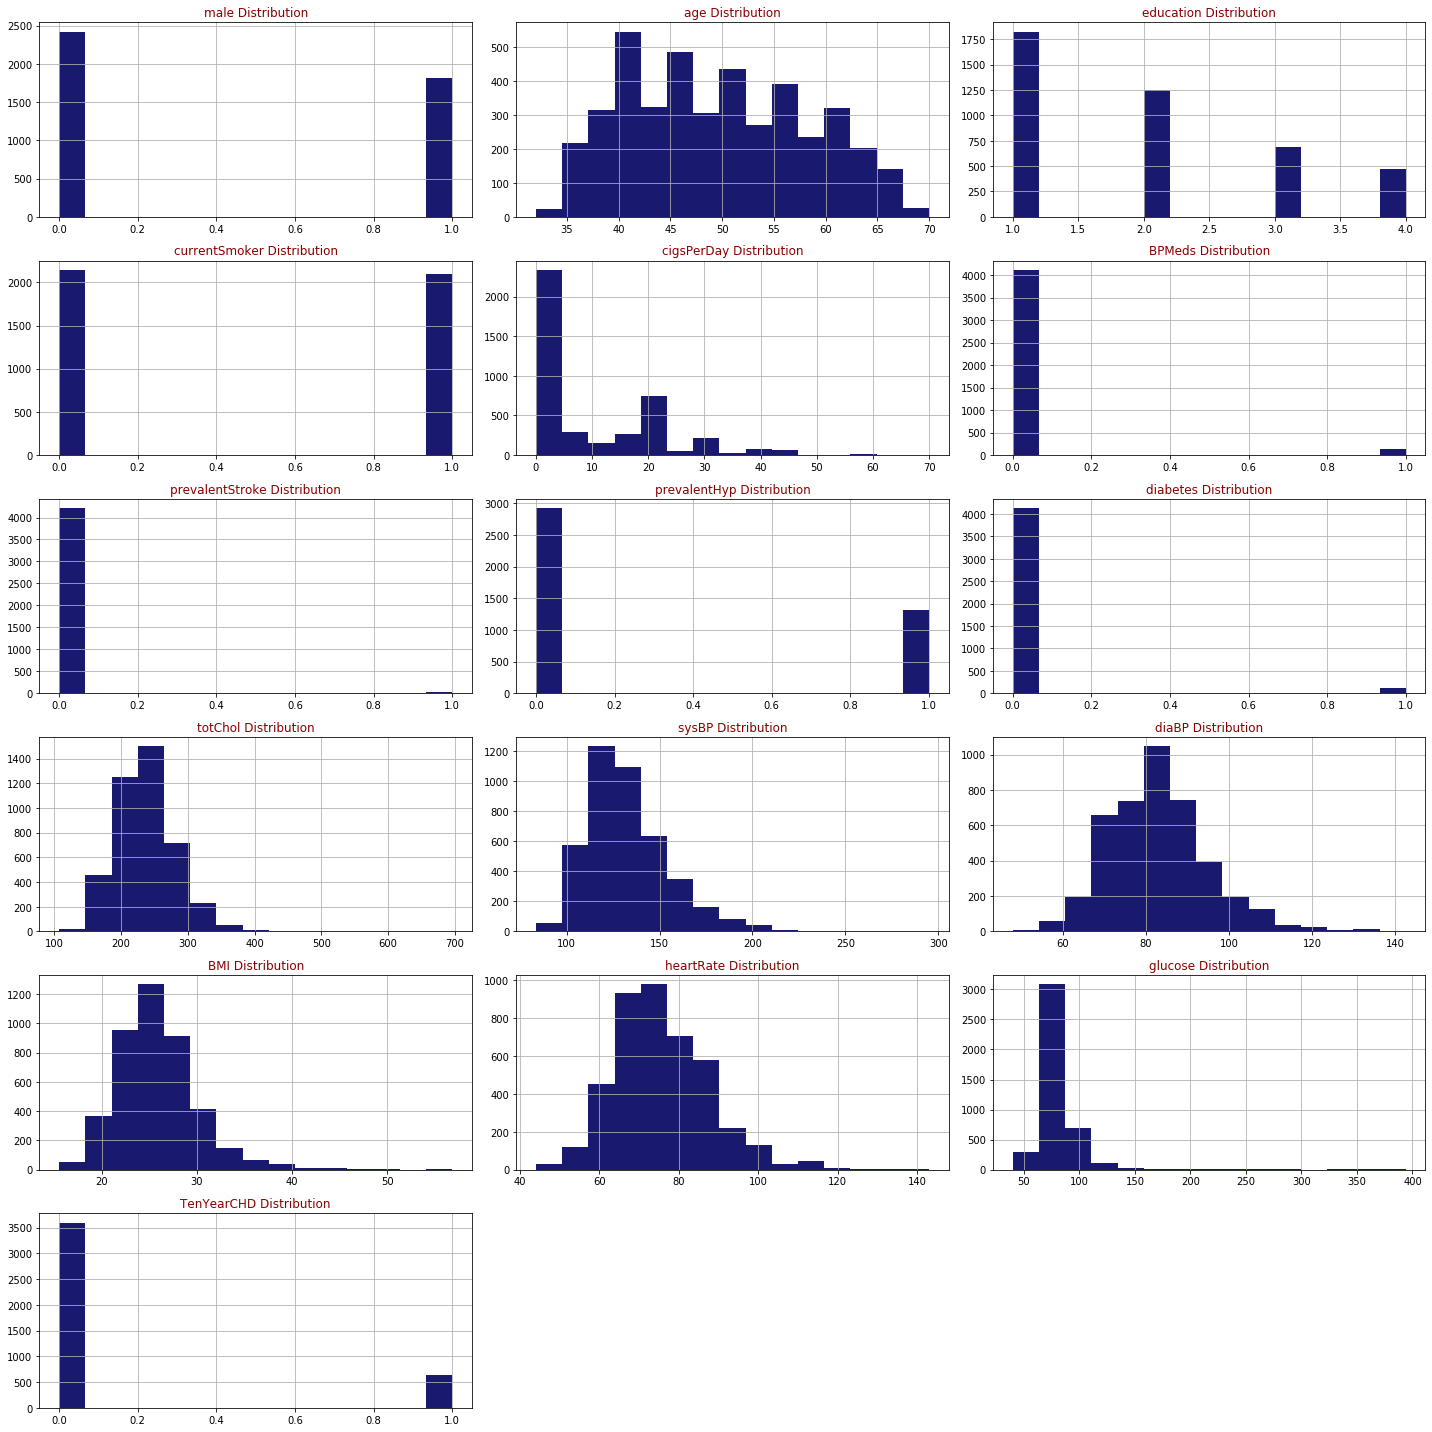

In [10]:
# A nice thing to have in front of the eyes: all histograms together
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=15,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

### A quick baseline

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [10]:
features = df.iloc[:,:-1]
result = df.iloc[:,-1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

([<matplotlib.axis.XTick at 0x1b5faba8>,
 <a list of 15 Text xticklabel objects>)

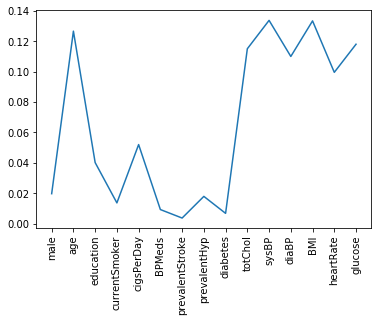

In [13]:
# what features are the most important?
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90)

In [14]:
# View a list of the features and their importance scores
list(zip(features, rf.feature_importances_))

[('male', 0.019754008536523093),
 ('age', 0.12663541030461506),
 ('education', 0.040219650586746036),
 ('currentSmoker', 0.013709302351836284),
 ('cigsPerDay', 0.052050020172309995),
 ('BPMeds', 0.009330646049754778),
 ('prevalentStroke', 0.0037467333945932894),
 ('prevalentHyp', 0.017988918743342543),
 ('diabetes', 0.006831309722008269),
 ('totChol', 0.11505164721758787),
 ('sysBP', 0.1337231030904456),
 ('diaBP', 0.10999127685575931),
 ('BMI', 0.13337469793247148),
 ('heartRate', 0.09955420248780458),
 ('glucose', 0.11803907255420176)]

In [15]:
# Making predictions on unseen data
predictions_rf = rf.predict(X_test)

In [16]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       724
           1       0.30      0.05      0.08       124

    accuracy                           0.84       848
   macro avg       0.58      0.51      0.50       848
weighted avg       0.78      0.84      0.79       848



In [17]:
print(confusion_matrix(y_test, predictions_rf))

[[710  14]
 [118   6]]


In [18]:
accuracy_score(y_test, predictions_rf)

0.8443396226415094

In [19]:
# Under ROC curve
prob_rf = rf.predict_proba(X_test)
prob_rf = [p[1] for p in prob_rf]
print(roc_auc_score(y_test, prob_rf))

0.681702236677954


### Logistic regression (normalized features)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [21]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [22]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train_std, y_train)
predictions_y_2 = logmodel.predict(X_test_std)

In [23]:
print(classification_report(y_test, predictions_y_2))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.40      0.05      0.09       124

    accuracy                           0.85       848
   macro avg       0.63      0.52      0.50       848
weighted avg       0.79      0.85      0.80       848



In [24]:
print(confusion_matrix(y_test, predictions_y_2))

[[715   9]
 [118   6]]


In [25]:
accuracy_score(y_test, predictions_y_2)

0.8502358490566038

In [26]:
# Under ROC curve
prob_y_2 = logmodel.predict_proba(X_test_std)
prob_y_2 = [p[1] for p in prob_y_2]
print(roc_auc_score(y_test, prob_y_2))

0.7551015861700232


### Parameters choosing

In [27]:
from sklearn.model_selection import GridSearchCV
weights = np.linspace(0.03, 0.97, 55)

In [28]:
# gridsearch should be done on the big dataset, before it's split in train and test. Thus, normalizing features
scaler = StandardScaler()
features_std = scaler.fit_transform(features)

In [29]:
gsc = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='roc_auc',
    cv=3
)
grid_result = gsc.fit(features_std, result)

In [31]:
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.882962962962963, 1: 0.11703703703703705}}


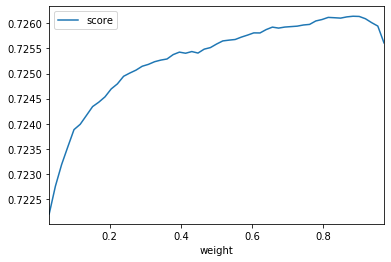

In [32]:
# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [33]:
# passing weights found above
rf_w = RandomForestClassifier(class_weight = {0:0.882962962962963, 1:0.11703703703703705})
rf_w.fit(X_train, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.882962962962963,
                                     1: 0.11703703703703705},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [34]:
# Making predictions on unseen data
predictions_rf_w = rf_w.predict(X_test)

In [35]:
# a bit worse than with default parameters
print(classification_report(y_test, predictions_rf_w))
print(confusion_matrix(y_test, predictions_rf_w))
accuracy_score(y_test, predictions_rf_w)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       724
           1       0.45      0.12      0.19       124

    accuracy                           0.85       848
   macro avg       0.66      0.55      0.55       848
weighted avg       0.81      0.85      0.81       848

[[706  18]
 [109  15]]


0.8502358490566038

#### Adding class_weight='balanced'

In [36]:
logmodel = LogisticRegression(solver='liblinear', class_weight='balanced')
logmodel.fit(X_train_std, y_train)
predictions_y_3 = logmodel.predict(X_test_std)

In [37]:
# fewer Type II errors but less accurate 
print(classification_report(y_test, predictions_y_3))
print(confusion_matrix(y_test, predictions_y_3))
accuracy_score(y_test, predictions_y_3)
# Under ROC curve
prob_y_3 = logmodel.predict_proba(X_test_std)
prob_y_3 = [p[1] for p in prob_y_3]
print(roc_auc_score(y_test, prob_y_3))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       724
           1       0.28      0.73      0.40       124

    accuracy                           0.68       848
   macro avg       0.61      0.70      0.59       848
weighted avg       0.84      0.68      0.73       848

[[488 236]
 [ 34  90]]
0.7555360007128855


### Passing weights manually

In [38]:
df['TenYearCHD'].value_counts(normalize = True)

0    0.848113
1    0.151887
Name: TenYearCHD, dtype: float64

In [39]:
# weights = {0 : '0.09042', 1 : '0.90958'}
weights = {0 : '0.848113', 1 : '0.151887'}
logmodel_auto = LogisticRegression(class_weight = weights, solver = 'liblinear')
logmodel_auto.fit(X_train_std, y_train)
predictions_std_auto = logmodel_auto.predict(X_test_std)

In [40]:
print(classification_report(y_test, predictions_std_auto))
print(confusion_matrix(y_test, predictions_std_auto))
accuracy_score(y_test, predictions_std_auto)
# Under ROC curve
prob_y_4 = logmodel.predict_proba(X_test_std)
prob_y_4 = [p[1] for p in prob_y_4]
print(roc_auc_score(y_test, prob_y_4))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       724
           1       0.00      0.00      0.00       124

    accuracy                           0.85       848
   macro avg       0.43      0.50      0.46       848
weighted avg       0.73      0.85      0.79       848

[[724   0]
 [124   0]]
0.7555360007128855


C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Upsampling/downsampling manually

In [41]:
from sklearn.utils import resample

In [42]:
df_minority = df[df.TenYearCHD==1]
df_majority = df[df.TenYearCHD==0]

In [43]:
df['TenYearCHD'].value_counts()

0    3596
1     644
Name: TenYearCHD, dtype: int64

In [44]:
# Upsample minority class
# sample with replacement to match majority class and get reproducible results
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=3596,    
                                 random_state=123) 
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.TenYearCHD.value_counts()

1    3596
0    3596
Name: TenYearCHD, dtype: int64

In [45]:
# Train/test, normalize the new data set
features_upsampled = df_upsampled.iloc[:,:-1]
result_upsampled = df_upsampled.iloc[:,-1]

X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(features_upsampled, result_upsampled, test_size = 0.2, random_state = 14)

X_train_std_upsampled = scaler.fit_transform(X_train_upsampled)
X_test_std_upsampled = scaler.fit_transform(X_test_upsampled)

In [46]:
# new log model for upsampled data
logmodel_upsampled = LogisticRegression(solver='liblinear')
logmodel_upsampled.fit(X_train_std_upsampled, y_train_upsampled)
predictions_y_2_upsampled = logmodel_upsampled.predict(X_test_std_upsampled)

In [47]:
# very poor results
print(classification_report(y_test_upsampled, predictions_y_2_upsampled))
print(confusion_matrix(y_test_upsampled, predictions_y_2_upsampled))
accuracy_score(y_test_upsampled, predictions_y_2_upsampled)
# Under ROC curve
prob_y_2_upsampled = logmodel_upsampled.predict_proba(X_test_std_upsampled)
prob_y_2_upsampled = [p[1] for p in prob_y_2_upsampled]
print(roc_auc_score(y_test_upsampled, prob_y_2_upsampled))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       738
           1       0.67      0.71      0.69       701

    accuracy                           0.69      1439
   macro avg       0.69      0.69      0.69      1439
weighted avg       0.69      0.69      0.69      1439

[[494 244]
 [204 497]]
0.748369537903653


#### Lowering the threshold

In [48]:
logmodel_lowering = LogisticRegression(solver='liblinear')
logmodel_lowering.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:

from sklearn.preprocessing import binarize
for i in range(1,7):
    cm2=0
    predictions_y_2_lowering = logmodel_lowering.predict_proba(X_test_std)
    y_pred2_lowering=binarize(predictions_y_2_lowering,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2_lowering)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')


With 0.1 threshold the Confusion Matrix is  
 [[336 388]
 [ 14 110]] 
 with 446 correct predictions and 14 Type II errors( False Negatives) 

 Sensitivity:  0.8870967741935484 Specificity:  0.46408839779005523 



With 0.2 threshold the Confusion Matrix is  
 [[570 154]
 [ 51  73]] 
 with 643 correct predictions and 51 Type II errors( False Negatives) 

 Sensitivity:  0.5887096774193549 Specificity:  0.787292817679558 



With 0.3 threshold the Confusion Matrix is  
 [[661  63]
 [ 90  34]] 
 with 695 correct predictions and 90 Type II errors( False Negatives) 

 Sensitivity:  0.27419354838709675 Specificity:  0.9129834254143646 



With 0.4 threshold the Confusion Matrix is  
 [[695  29]
 [110  14]] 
 with 709 correct predictions and 110 Type II errors( False Negatives) 

 Sensitivity:  0.11290322580645161 Specificity:  0.9599447513812155 



With 0.5 threshold the Confusion Matrix is  
 [[715   9]
 [118   6]] 
 with 721 correct predictions and 118 Type II errors( False Negatives) 

 S

### Feature selection using Random Forest

In [53]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [54]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [57]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.12
sfm = SelectFromModel(clf, threshold=0.12)

# Train the selector
sfm.fit(X_train_std, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=2,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
                                                 warm_sta

In [56]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

NameError: name 'feat_labels' is not defined

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train_std.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_std.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_std.shape[1]), indices)
plt.xlim([-1, X_train_std.shape[1]])
plt.show()

In [ ]:
# with only imporant features - there are five of them. Can check X_important_train.shape[1]
X_important_train = sfm.transform(X_train_std)
X_important_test = sfm.transform(X_test_std)

In [ ]:
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)

In [ ]:
predictions_y_4 = clf_important.predict(X_important_test)

In [ ]:
print(classification_report(y_test, predictions_y_4))

In [ ]:
print(confusion_matrix(y_test, predictions_y_4))

In [ ]:
accuracy_score(y_test, predictions_y_4)

In [ ]:
# Under ROC curve
prob_y_4 = clf_important.predict_proba(X_important_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(roc_auc_score(y_test, prob_y_4))

In [ ]:
# View a list of the features and their importance scores
list(zip(features, clf_important.feature_importances_))

### With XGBoost

In [58]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import graphviz

In [59]:
data_dmatrix = xgb.DMatrix(data=X_train_std,label=y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [60]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.08,
                max_depth = 7, alpha = 10, n_estimators = 10)

In [61]:
xg_reg.fit(X_train_std,y_train)
prediction_y_5 = xg_reg.predict(X_test_std)

[11:01:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [62]:
rmse = np.sqrt(mean_squared_error(y_test, prediction_y_5))
print("RMSE: %f" % (rmse))

RMSE: 0.380087


#### Doing cross-validation

In [65]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(xg_reg, X_train_std, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#### Learning curve

In [71]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [70]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\us61565\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

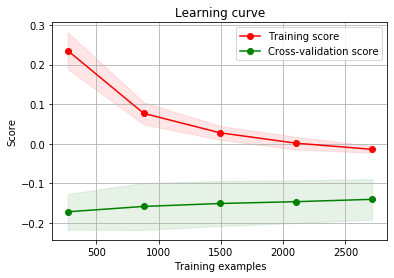

In [74]:
title = 'Learning curve'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(xg_reg, title, X_train_std, y_train, cv=cv, n_jobs=4)

In [63]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[11:10:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [64]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.476470,0.000901,0.476607,0.000458
1,0.456114,0.001594,0.456286,0.001067
2,0.438538,0.002163,0.438937,0.001776
3,0.423927,0.002645,0.424532,0.002382
4,0.411273,0.002660,0.412264,0.003599


In [59]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.3463
Name: test-rmse-mean, dtype: float64


In [60]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[19:11:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

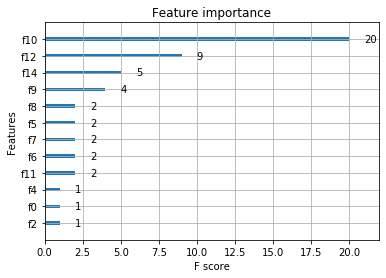

In [62]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Ensembles

In [76]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

In [89]:
m = KNeighborsClassifier(n_neighbors=3)
bag = BaggingClassifier(
    m, 
    max_samples=.5, 
    max_features=6, 
    n_jobs=5,
    oob_score=True)
bag.fit(X_train_std, y_train)

bag.oob_score_
bag.score(X_train_std, y_train)

0.8576061320754716

In [80]:
adab = AdaBoostClassifier(base_estimator=None, n_estimators=100)
adab.fit(X_train_std, y_train)
adab.score(X_train_std, y_train)

0.8614386792452831

In [90]:
m = VotingClassifier(
    estimators=[('Kneigh', KNeighborsClassifier()), 
                ('AdaBoost', AdaBoostClassifier()), 
                ('RandomForest', RandomForestClassifier())], 
    voting='hard')

In [ ]:
m.fit(X_train_std, y_train)

In [92]:
m.score(X_train_std, y_train)

0.8829599056603774